In [1]:
import torch
from pixlens.editing.controlnet import ControlNet
from pixlens.editing.pix2pix import Pix2pix
pizza = r"C:\Users\lluis\Downloads\pizza.jpg"
prompt = "Make the pizza smaller"


c:\Users\lluis\miniconda3\envs\pixlens\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [15]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image

# download an image
image = Image.open(pizza)
image = np.array(image)

# get canny image
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

# generate image
generator = torch.manual_seed(0)
image = pipe(
    prompt, num_inference_steps=10, generator=generator, image=canny_image, guidance_scale= 7.5
).images[0]

Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:05,  1.00it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


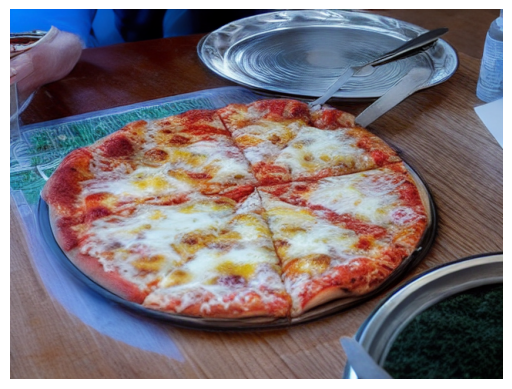

In [17]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [7]:

pix2pix = Pix2pix(device=torch.device("cuda")).from_yaml("../model_cfgs/instruct_pix2pix.yaml")  
pix2pix.edit(image_path=pizza, prompt = prompt)


Loading pipeline components...: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


RuntimeError: "LayerNormKernelImpl" not implemented for 'Half'

In [8]:
import PIL
from PIL import Image
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionDiffEditPipeline, DDIMScheduler, DDIMInverseScheduler



pipe = StableDiffusionDiffEditPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.inverse_scheduler = DDIMInverseScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

mask_prompt = "A pizza"

init_image = Image.open(pizza)

mask_image = pipe.generate_mask(image=init_image, source_prompt=prompt, target_prompt=mask_prompt)
image_latents = pipe.invert(image=init_image, prompt=mask_prompt).latents
image = pipe(prompt=prompt, mask_image=mask_image, image_latents=image_latents).images[0]

Loading pipeline components...: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]
The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
  0%|          | 0/40 [00:00<?, ?it/s]c:\Users\lluis\miniconda3\envs\pixlens\Lib\site-packages\diffusers\configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMInverseScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMInverseScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 40/40 [00:06<00:00,  6.10it/s]


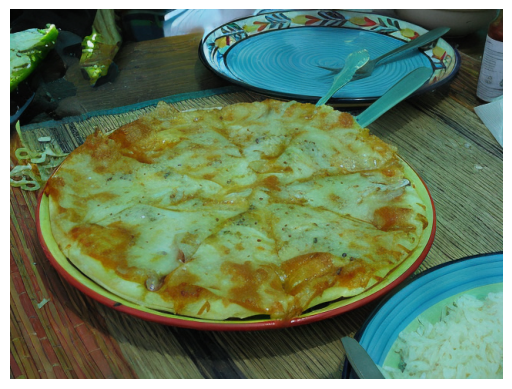

In [9]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [12]:
from diffusers import AutoPipelineForImage2Image
import torch
import PIL

pipe = AutoPipelineForImage2Image.from_pretrained("SimianLuo/LCM_Dreamshaper_v7")
# To save GPU memory, torch.float16 can be used, but it may compromise image quality.
pipe.to(torch_device="cuda", torch_dtype=torch.float32)
image = PIL.Image.open(pizza)

# Can be set to 1~50 steps. LCM support fast inference even <= 4 steps. Recommend: 1~8 steps.
num_inference_steps = 8
images = pipe(
    prompt=prompt, image=image, num_inference_steps=num_inference_steps, guidance_scale=8.
)

100%|██████████| 8/8 [00:01<00:00,  4.27it/s]


In [28]:
images.images[0].shape

(480, 640, 3)

In [ ]:
image

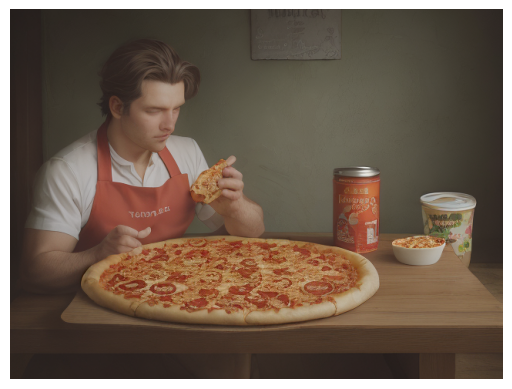

In [14]:
plt.imshow(images.images[0])
plt.axis('off')  # Turn off axis numbers
plt.show()
